# Dog Breed Classification using Transfer Learning in AWS Sagemaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.


This project demonstrates using a pretrained image classification model to identify dog breeds from images. We leverage transfer learning to adapt the pretrained model for dog breed classification. The implementation includes:

- Hyperparameter tuning
- Model training
- Debugger and Profiler reporting
- AWS SageMaker deployment

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import os
import boto3
from PIL import Image
import io
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Dataset Description
This project utilizes a dog breed dataset comprising 133 distinct breeds. The dataset is organized into three subsets:

Training set: 6,680 images

Validation set: 835 images

Test set: 836 images

Class Distribution (Training Set)

Largest class: Alaskan_malamute (77 images)

Smallest class: 26 images

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip


In [35]:
!aws s3 cp dogImages s3://udacityawsproject3gt/ --recursive --quiet

In [12]:
def count_files_in_subfolders(root_folder):
    total_files = 0
    for dirpath, dirnames, filenames in os.walk(root_folder):
        total_files += len(filenames)
    return total_files


folder_path = os.path.join(os.getcwd(),'dogImages/train')
file_count = count_files_in_subfolders(folder_path)
print(f"Total files in train folders: {file_count}")
folder_path = os.path.join(os.getcwd(),'dogImages/test')
file_count = count_files_in_subfolders(folder_path)
print(f"Total files in test folders: {file_count}")
folder_path = os.path.join(os.getcwd(),'dogImages/valid')
file_count = count_files_in_subfolders(folder_path)
print(f"Total files in validation folders: {file_count}")

Total files in train folders: 6680
Total files in test folders: 836
Total files in validation folders: 835


In [105]:
current_dir = os.path.join(os.getcwd(), 'dogImages/train')
file_dict = {}

for dirpath, _, filenames in os.walk(current_dir):
    rel_path = os.path.relpath(dirpath, current_dir)
    if rel_path == '.':  # Skip the root folder itself
        continue
    file_dict[rel_path] = len(filenames)

print("Folders sorted by file count (highest first):")
for folder in sorted(file_dict, key=lambda x: file_dict[x], reverse=True):
    print(f"{folder}: {file_dict[folder]} files")

Folders sorted by file count (highest first):
005.Alaskan_malamute: 77 files
029.Border_collie: 74 files
015.Basset_hound: 73 files
057.Dalmatian: 71 files
014.Basenji: 69 files
039.Bull_terrier: 69 files
041.Bullmastiff: 69 files
046.Cavalier_king_charles_spaniel: 67 files
008.American_staffordshire_terrier: 66 files
011.Australian_cattle_dog: 66 files
012.Australian_shepherd: 66 files
087.Irish_terrier: 66 files
023.Bernese_mountain_dog: 65 files
032.Boston_terrier: 65 files
036.Briard: 65 files
056.Dachshund: 65 files
001.Affenpinscher: 64 files
006.American_eskimo_dog: 64 files
021.Belgian_sheepdog: 64 files
027.Bloodhound: 64 files
034.Boxer: 64 files
044.Cane_corso: 64 files
076.Golden_retriever: 64 files
004.Akita: 63 files
042.Cairn_terrier: 63 files
068.Flat-coated_retriever: 63 files
115.Papillon: 63 files
017.Bearded_collie: 62 files
020.Belgian_malinois: 62 files
024.Bichon_frise: 62 files
051.Chow_chow: 62 files
071.German_shepherd_dog: 62 files
061.English_cocker_spaniel:

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}
# objective_metric_name = "average test loss"
# objective_type = "Minimize"
# metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [3]:
BUCKET = 'udacityawsproject3gt'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

In [11]:
#TODO: Create estimators for your HPs

# estimator = # TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

# tuner = # TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [12]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://{BUCKET}/"}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-06-19 03:02:28 Starting - Found matching resource for reuse
2025-06-19 03:02:28 Downloading - Downloading the training image
2025-06-19 03:02:28 Training - Training image download completed. Training in progress.
2025-06-19 03:02:28 Uploading - Uploading generated training model
2025-06-19 03:02:28 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.0017379304537316156',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-06-19-02-09-55-034"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-302263042486/pytorch-training-2025-06-19-02-09-55-034/source/sourcedir.tar.gz"'}

In [ ]:
best_hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr']
                  }
best_hyperparameters

In [8]:
best_hyperparameters = {'batch-size': 32, 'lr': '0.0017379304537316156'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [51]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [52]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="BASIC",
    role=role,
    instance_count=2,
    instance_type="ml.m7i.2xlarge",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": f"s3://{BUCKET}/"}) # TODO: Your estimator here

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: BASIC-2025-06-24-07-14-29-534


2025-06-24 07:14:30 Starting - Starting the training job...
2025-06-24 07:14:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-06-24 07:15:29 Downloading - Downloading input data......
2025-06-24 07:16:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-24 07:16:32,412 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-24 07:16:32,414 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-24 07:16:32,420 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-24 07:16:32,422 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-06-24 07:16:32,567 sagemak

In [53]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'BASIC-2025-06-24-07-14-29-534',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:302263042486:training-job/BASIC-2025-06-24-07-14-29-534',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '32',
  'lr': '"0.0017379304537316156"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"BASIC-2025-06-24-07-14-29-534"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-cpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::302263042486:role/service-rol

In [54]:
# client = estimator.sagemaker_session.sagemaker_client
# description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
# # print(description)

In [58]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial("s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/debug-output/")

[2025-06-24 08:12:06.312 default:164 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/debug-output/


In [59]:
trial.tensor_names()

[2025-06-24 08:12:09.723 default:164 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-06-24 08:12:10.737 default:164 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [60]:
# TODO: Plot a debugging output.

In [61]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
  
    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label='train_' + tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

completed TRAIN plot
completed EVAL plot


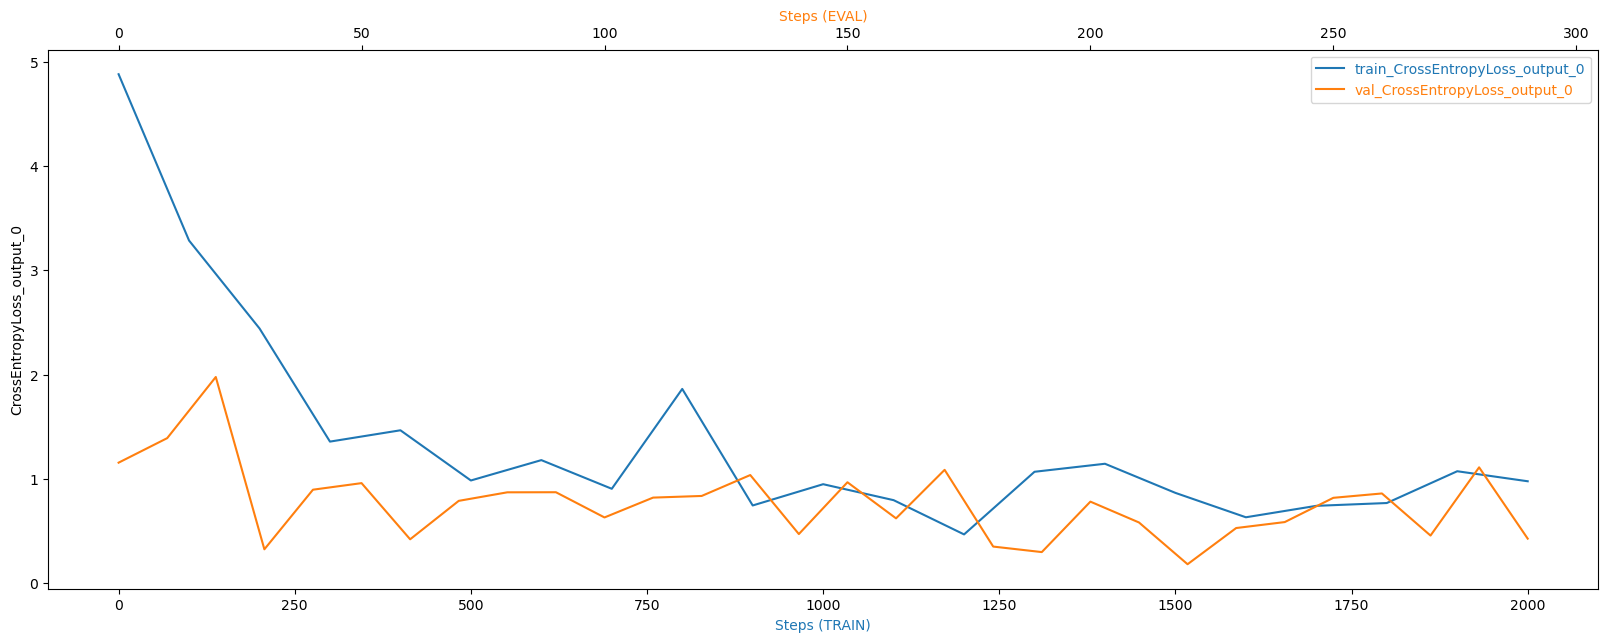

In [63]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
Yes — validation loss shows abnormal behavior.

Anomalies Identified:
Validation loss starts too low: likely data leakage, inconsistent preprocessing, or dropout incorrectly applied in eval.

Early increase and plateau: indicates potential overfitting, or instability due to high learning rate or batch variation.

Possible Fixes:
Double-check for data leakage (same users/samples in both sets?).

Consider reducing learning rate or increasing batch size.

Add early stopping to catch overfitting before performance worsens.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [10]:
# TODO: Display the profiler output
import boto3
session = boto3.session.Session()
region = session.region_name

job_name = "BASIC-2025-06-24-07-14-29-534" # put a job name here to load it
estimator = sagemaker.estimator.Estimator.attach(job_name)

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


2025-06-24 08:12:51 Starting - Preparing the instances for training
2025-06-24 08:12:51 Downloading - Downloading the training image
2025-06-24 08:12:51 Training - Training image download completed. Training in progress.
2025-06-24 08:12:51 Uploading - Uploading generated training model
2025-06-24 08:12:51 Completed - Training job completed
Training jobname: BASIC-2025-06-24-07-14-29-534
Region: us-east-1


In [137]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-302263042486/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/profiler-output


Profiler data from system is available


In [138]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output


In [139]:
! aws s3 ls {rule_output_path} --recursive

2025-06-24 08:10:48     381824 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-06-24 08:10:47     229851 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-06-24 08:10:43        192 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-06-24 08:10:43        201 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-06-24 08:10:43       1971 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-06-24 08:10:43        127 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-06-24 08:10:43        200 BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2025-06-24 08:10:43        119 BASIC-2025-06-24-07-14

In [140]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/rule-output/

In [143]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [144]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [11]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [12]:
estimator.model_data

's3://sagemaker-us-east-1-302263042486/BASIC-2025-06-24-07-14-29-534/output/model.tar.gz'

In [15]:
# TODO: Deploy your model to an endpoint
role = sagemaker.get_execution_role()
pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) # TODO: Add your deployment configuration like instance type and number of instances

In [16]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [19]:
from sagemaker.predictor import Predictor
predictor = ImagePredictor(
    endpoint_name='pytorch-inference-2025-06-24-09-15-31-238',
    sagemaker_session=sagemaker.Session()
)

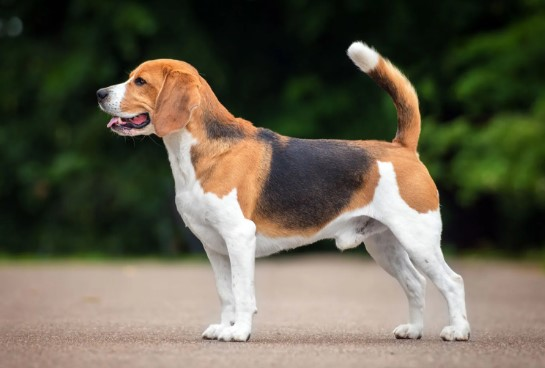

In [20]:
with open("Beagle dog.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

Image.open(io.BytesIO(img_bytes))

In [21]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [22]:
response

{'predicted_class': 15, 'probability': 0.6729040741920471}

In [23]:
# get list of class names
import boto3
BUCKET = 'udacityawsproject3gt'
s3 = boto3.client('s3')
bucket_name = BUCKET
prefix = 'train/' 
result = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix=prefix,
    Delimiter='/'
)

subfolders = [common_prefix['Prefix'].split('/')[-2] 
              for common_prefix in result.get('CommonPrefixes', [])]

print(subfolders)  

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [9]:
subfolders[response['predicted_class']]

'016.Beagle'

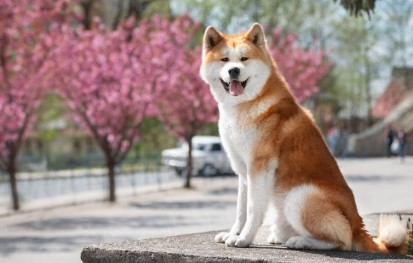

In [131]:
with open("Akita dog.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

Image.open(io.BytesIO(img_bytes))

In [132]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
subfolders[response['predicted_class']]

'004.Akita'

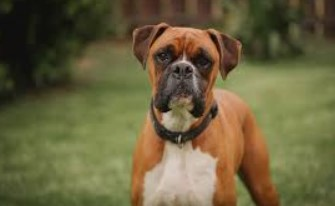

In [134]:
with open("boxer dog.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

Image.open(io.BytesIO(img_bytes))


In [135]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
subfolders[response['predicted_class']]

'034.Boxer'

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()